# Exploring Feature Selection 
Rapid biotechnological advancements have made it possible for researchers to produce information-rich genomic datasets [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2253491/). Various statistical tests and machine learning approaches are being used to analyze these large volumes of data, often to build a classification model that can predict the patient’s response based on their genome. Feature selection is very important when working with large datasets because it can improve the accuracy of the model as well as reduce its training time [[2]](https://journals.sagepub.com/doi/full/10.1177/2055207620914777), so we will explore different feature selection methods and the effect they have on the classification model through established evaluation metrics.  

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import statsmodels.stats.multitest
import sklearn.preprocessing
import seaborn as sns
from tabulate import tabulate

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Methods

### 1.1 Dataset Description
I will be using a dataset containing genomic information on breast cancer patients. Samples were taken either by FNA (Fine needle aspiration) or core biopsy from the primary tumor of patients with breast cancer before initiating neoadjuvant chemotherapy, and these patients were later assessed to see if they responded to the chemo or not. Patients with no residual tumor in the breast and the axillary lymph node were labeled as pathological complete response (pCR), while patients with a residual disease in either the breast, axilla, or both, were labeled as residual disease (RD). The data was obtained through Affymetrix arrays and consists of normalized gene expression levels of 13,300 genes in 178 patients, 152 of which are labeled as RD and 26 as pCR. For the purpose of building a binary classifier, I labeled the RD response group as Class 1 and the pCR response group as Class 0. Also note that when building the models, I would have to account for the difference in class size because this imbalance introduces bias towards the majority group. 

In [3]:
# load data
fpath = "C:\\Users\\d0156\\OneDrive\\Desktop\\Spring 2021\\CMM\\Project\\data10.csv"
dat = pd.read_csv(fpath, index_col=0, low_memory=False).T
dat.head()

,response,MIR4640///DDR1,RFC2,HSPA6,PAX8,GUCA1A,MIR5193///UBA7,THRA,PTPN21,CCL5,...,MROH7TTC4///TTC4,RBM12B,ZGPAT///LIME1,LOC102725263///LOC389906,LOC100129924///C1orf50,FAM86DP///FAM86B2///FAM86FP///FAM86B1///FAM86C1,SNHG17,HNRNPUL2BSCL2///HNRNPUL2,LOC100505915,NPEPL1
GSM508013,RD,10.1814877283334,7.94820367793715,7.96744531278059,11.1257621549869,5.61328411047407,7.40905992695229,7.49063430584449,7.01089170592973,8.89449645510563,...,8.17205240918307,7.0090447873825,8.01866198990004,7.5907292540907,9.15942483933206,7.62032247868161,7.5067320449344,6.52870570578039,7.9494123687662,6.52269921741651
GSM508014,RD,10.8824137893501,8.81408572802569,8.65194143757924,10.9827155582512,6.17070024169963,7.42113912553038,8.0739540875927,6.66918270878574,7.59867039976104,...,8.59997605166759,7.2588392367952,8.29838796818485,8.19972141526173,8.76333189470853,7.40852505932414,6.96265312641013,6.20413093284513,8.33124391166031,6.88736685802847
GSM508015,RD,10.5430414897606,8.21494075441538,8.11739375720765,11.0602635987383,5.92979573096228,7.97794386841615,8.47950948072584,7.32525147951884,8.66233725636533,...,8.61998516224943,7.90093924273341,8.27275573830138,8.33079142091719,8.56261259212211,7.93794460545561,6.87870082232136,6.43292267151801,7.96202839277775,7.20306408594419
GSM508016,RD,11.6737595713366,8.26971579572424,8.28026040187849,10.5885928444966,5.41574852760681,7.73344925163922,7.51020240620857,6.80588571675781,7.36211916672566,...,8.44705015545719,7.0663798534599,8.15479786055856,7.5680397074865,8.78347302471763,7.48914951897497,6.90961711570622,5.99354530133689,8.00564700341666,6.62208990024421
GSM508017,RD,11.0798980660884,8.01481833626731,8.06691796369235,10.7723888101784,5.51902287880249,8.04676387523535,7.68168116861799,6.77429949122642,7.40650265681287,...,8.41233696454055,7.11504365016171,8.2474291280948,8.11489794231288,8.86711190879589,7.28173533689825,6.92671109909728,6.21156906599368,8.18461751869607,6.91146389608456


In [4]:
# get data with RD response
rd = dat[dat['response'] == 'RD']
rd.loc[:, 'response'] = 1

# get data with pCR response
pcr = dat[dat['response'] == 'pCR']
pcr.loc[:, 'response'] = 0

# get attributes
numgenes = dat.shape[1]
numpatients = dat.shape[0]
numrd = rd.shape[0]
numpcr = pcr.shape[0]

print(f'Total Number of Genes: {numgenes}')
print(f'Total Number of Patients: {numpatients}')
print(f'Number of patients with RD response: {numrd}')
print(f'Number of patients with pCR response: {numpcr}')

Total Number of Genes: 13300
Total Number of Patients: 178
Number of patients with RD response: 152
Number of patients with pCR response: 26


C:\Users\d0156\anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


### 1.2 Feature Selection

The following is a list of feature selection methods that I used to build binary classification models, accounting for the class imbalance by weighing the classes based on its frequency. 
- **Wilcoxon rank-sum:** Under the null hypothesis that one sample does not depend on the other, the Wilcoxon rank-sum test tests whether the two samples are drawn from the same distribution [[3]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html). I set the significance level to be 0.05, and I performed Benjamini-Hochberg to correct p-values for false discovery rate to account for multiple testing.
- **Kendall’s rank correlation coefficient:** Highly correlated features negatively affect the performance of the classification model by introducing bias towards the group of correlated features, potentially masking predictive features [[4]](https://academic.oup.com/bioinformatics/article/27/14/1986/194387). I used Kendall’s rank correlation coefficient, a non-parametric test that quantifies the associativity between two variables, to filter out any features that had a coefficient higher than 0.8. Note that this method was used after the dataset was filtered with the Wilcoxon rank-sum test because the original dataset had too many datapoints to conduct a pairwise analysis such as Kendall’s rank. I will compare classifier performance based on just Wilcoxon rank-sum to that based on Wilcoxon rank-sum and Kendall’s rank. 
- **Mutual information:** Mutual information quantifies the statistical dependency between two random variables, which can be used as a metric for feature selection. In machine learning, this can be thought of as how much information a certain feature (gene) contributes to the classification. I examined its performance based on k-values of 10, 100, 500, 1000, and 5000, representing the number of features that were selected. 
- **Principal component analysis (PCA):** PCA is a very useful dimensionality reduction technique that simplifies the dataset while maximizing its variance. It is most often used as a way to transform the data and not necessarily for feature selection, but its algorithm, selecting for principal components, provides a reasonable framework for selecting important features [[5]](https://medlineplus.gov/genetics/gene/ccnd2/). I examined its performance based on k-values (number of components) of 10, 20, 30, 50, 100, representing the number of features that were selected. 

### 1.3 Evaluation
Each of the feature selection methods described above were used to build four different binary classification models – Logistic regression, Support vector machine (SVM), Random forest, and Gaussian Naïve-Bayes. The performance of these models were evaluated through stratified 3-fold cross validation, ensuring the models were being trained and tested with the same split datasets within each fold. Note that the class distribution was maintained across each fold, and the class imbalance bias was addressed by assigning different weights to each class based on its frequency. The performance of each model within each fold for each varying k-value (for feature selection based on mutual information and PCA) was evaluated through its F2 score, a weighted harmonic mean of precision and recall favoring recall, and its average value over the folds is reported. The absolute number of errors, obtained by direct comparison between the predicted labels and the true labels, is also reported for the Wilcoxon rank-sum statistic and Kendall’s rank correlation coefficient. Note that the testing set contains 59 data points, based on the splitting done for 3-fold cross validation. 

In [25]:
# import modules
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import fbeta_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

## 2. Results

### 2.1 Wilcoxon Rank-Sum
Features with a corrected p-value of less than 0.05 were selected.

In [28]:
# preprocess data
genes = rd.append(pcr)
X = genes.drop(columns = ['response'], axis=1)
y = genes['response']

In [34]:
# split for 3-fold cross validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 

logreg_errors = []
svm_errors = []
clf_errors = []
gnb_errors = []

logreg_f2scores = []
svm_f2scores = []
clf_f2scores = []
gnb_f2scores = []

for train, test in skf.split(X, y):
    # split into training and testing data
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    rd_train = X_train[y_train == 1]
    rd_ary = rd_train.to_numpy().astype(float) 
    pcr_train = X_train[y_train == 0]
    pcr_ary = pcr_train.to_numpy().astype(float)
    
    # Wilcoxon rank-sums test
    pvals = []
    for i in range(numgenes-1):
        w, p = scipy.stats.ranksums(rd_ary[:,i], pcr_ary[:,i])
        pvals.append(p)
    
    # Benjamini-Hochberg correction
    fdr_array, fdr_pvals = statsmodels.stats.multitest.fdrcorrection(pvals, alpha=0.05)
    
    # select features with a corrected p-value of less than 0.05
    features = []
    rel_idx = []
    for i in range(len(fdr_pvals)):
        if (fdr_pvals[i] < 0.05):
            features.append(X_train.columns[i])
            rel_idx.append(i)
    
    Xc_train = X_train.iloc[:,rel_idx]
    Xc_test = X_test.iloc[:,rel_idx]
    
    print(f'Remaining number of features: {Xc_train.shape[1]}')

    # fit and evaluate models
    logreg = LogisticRegression(solver='liblinear',class_weight='balanced',max_iter=500)
    logreg.fit(Xc_train, y_train)
    y_pred = logreg.predict(Xc_test)
    logreg_errors.append((y_test != y_pred).sum())
    logreg_f2scores.append(fbeta_score(y_test, y_pred, average='weighted', beta=2))
    
    svm = SVC(class_weight='balanced')
    svm.fit(Xc_train, y_train)
    y_pred = svm.predict(Xc_test)
    svm_errors.append((y_test != y_pred).sum())
    svm_f2scores.append(fbeta_score(y_test, y_pred, average='weighted', beta=2))
    
    clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy')
    clf.fit(Xc_train, y_train)
    y_pred = clf.predict(Xc_test)
    clf_errors.append((y_test != y_pred).sum())
    clf_f2scores.append(fbeta_score(y_test, y_pred, average='weighted', beta=2))
    
    gnb = GaussianNB()
    gnb.fit(Xc_train, y_train)
    y_pred = gnb.predict(Xc_test)
    gnb_errors.append((y_test != y_pred).sum())
    gnb_f2scores.append(fbeta_score(y_test, y_pred, average='weighted', beta=2))

print('\n')
print(tabulate({'Classifier': ['Logistic Regression', 'SVM', 'Random Forest', 'Gaussian NB'], \
                'Abs. Errors (Out of 59)': [logreg_errors, svm_errors, clf_errors, gnb_errors], \
               'Mean F2 Score': [np.mean(logreg_f2scores), np.mean(svm_f2scores), np.mean(clf_f2scores), \
                                np.mean(gnb_f2scores)]}, headers='keys'))

Remaining number of features: 855
Remaining number of features: 1034
Remaining number of features: 841


Classifier           Abs. Errors (Out of 59)      Mean F2 Score
-------------------  -------------------------  ---------------
Logistic Regression  [13, 8, 11]                       0.81214
SVM                  [15, 18, 15]                      0.738452
Random Forest        [10, 7, 9]                        0.829283
Gaussian NB          [19, 18, 14]                      0.722926


For each iteration, the remaining number of features were 855, 1034, and 841. Based on both the number of absolute errors and their mean F2 scores, the Random Forest classifier performed the best. 

### 2.2 Wilcoxon Rank-sum and Kendall's

After using the Wilcoxon rank-sum test to filter through the dataset for features with a corrected p-value of less than 0.05, feature pairs with a correlation coefficient greater than 0.8 were removed from the model to improve its performance.

In [14]:
# preprocess data
genes = rd.append(pcr)
X = genes.drop(columns = ['response'], axis=1)
y = genes['response']

In [19]:
# split for 3-fold cross validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 

logreg_errors = []
svm_errors = []
clf_errors = []
gnb_errors = []

logreg_f2scores = []
svm_f2scores = []
clf_f2scores = []
gnb_f2scores = []

for train, test in skf.split(X, y):
    # split into training and testing data
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    rd_train = X_train[y_train == 1].to_numpy().astype(float)
    pcr_train = X_train[y_train == 0].to_numpy().astype(float)
    
    # Wilcoxon rank-sums test
    pvals = []
    for i in range(numgenes-1):
        w, p = scipy.stats.ranksums(rd_train[:,i], pcr_train[:,i])
        pvals.append(p)
    
    # Benjamini-Hochberg correction
    adjust_array, adjust_pvals = statsmodels.stats.multitest.fdrcorrection(pvals, alpha=0.05)
    
    # select features with a corrected p-value of less than 0.05
    features = []
    rel_idx = []
    for i in range(len(adjust_pvals)):
        if adjust_pvals[i] < 0.05:
            features.append(X_train.columns[i])
            rel_idx.append(i)

    Xc_train_rs = X_train.iloc[:,rel_idx]
    Xc_test_rs = X_test.iloc[:,rel_idx]
    
    # remove highly correlated features
    correlated_features = set()
    correlation_matrix = Xc_train_rs.astype(float, copy=True).corr(method='kendall')

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

    Xc_train_rs.drop(labels=list(correlated_features), axis=1, inplace=True)
    Xc_test_rs.drop(labels=list(correlated_features), axis=1, inplace=True)

    print(f'Remaining number of features: {Xc_train_rs.shape[1]}')
    
    # fit and evaluate models
    logreg = LogisticRegression(solver='liblinear',class_weight='balanced',max_iter=500)
    logreg.fit(Xc_train_rs, y_train)
    y_pred = logreg.predict(Xc_test_rs)
    logreg_errors.append((y_test != y_pred).sum())
    logreg_f2scores.append(fbeta_score(y_test, y_pred, average='weighted', beta=2))
    
    svm = SVC(class_weight='balanced')
    svm.fit(Xc_train_rs, y_train)
    y_pred = svm.predict(Xc_test_rs)
    svm_errors.append((y_test != y_pred).sum())
    svm_f2scores.append(fbeta_score(y_test, y_pred, average='weighted', beta=2))
    
    clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy')
    clf.fit(Xc_train_rs, y_train)
    y_pred = clf.predict(Xc_test_rs)
    clf_errors.append((y_test != y_pred).sum())
    clf_f2scores.append(fbeta_score(y_test, y_pred, average='weighted', beta=2))
    
    gnb = GaussianNB()
    gnb.fit(Xc_train_rs, y_train)
    y_pred = gnb.predict(Xc_test_rs)
    gnb_errors.append((y_test != y_pred).sum())
    gnb_f2scores.append(fbeta_score(y_test, y_pred, average='weighted', beta=2))

print('\n')
print(tabulate({'Classifier': ['Logistic Regression', 'SVM', 'Random Forest', 'Gaussian NB'], \
                'Abs. Errors (Out of 59)': [logreg_errors, svm_errors, clf_errors, gnb_errors], \
               'Mean F2 Score': [np.mean(logreg_f2scores), np.mean(svm_f2scores), np.mean(clf_f2scores), \
                                np.mean(gnb_f2scores)]}, headers='keys'))

C:\Users\d0156\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Remaining number of features: 822


C:\Users\d0156\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Remaining number of features: 1000


C:\Users\d0156\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Remaining number of features: 819


Classifier           Abs. Errors (Out of 59)      Mean F2 Score
-------------------  -------------------------  ---------------
Logistic Regression  [12, 8, 12]                       0.814107
SVM                  [16, 20, 17]                      0.711874
Random Forest        [9, 7, 8]                         0.841558
Gaussian NB          [17, 18, 15]                      0.727775


For each iteration, the remaining number of features decreased to 822, 1000, and 819. Again, the Random Forest classifier performed the best. Note that the mean F2 scores increased slightly for all classifiers except for SVM. 

### 2.3 Mutual Information

The amount of mutual information the features have with the class labels were calculated, and the top k features were selected. The k values used were 10, 100, 500, 1000, 5000.

In [ ]:
# preprocess data
genes = rd.append(pcr)
X = genes.drop(columns = ['response'], axis=1)
y = genes['response']

In [23]:
# split for 3-fold cross validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 

logreg_scores = np.zeros((5, 3))
svm_scores = np.zeros((5, 3))
clf_scores = np.zeros((5, 3))
gnb_scores = np.zeros((5, 3))

logreg_f2scores = np.zeros((5, 3))
svm_f2scores = np.zeros((5, 3))
clf_f2scores = np.zeros((5, 3))
gnb_f2scores = np.zeros((5, 3))

kvals = [10, 100, 500, 1000, 5000]
for i in range(len(kvals)):
    k = kvals[i]
    j = 0
    for train, test in skf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        model = SelectKBest(score_func=mutual_info_classif, k=k)
        Xc_train = model.fit_transform(X_train,y_train)
        Xc_test = model.transform(X_test)

        # Fit models
        logreg = LogisticRegression(solver='liblinear',class_weight='balanced',max_iter=500)
        logreg.fit(Xc_train, y_train)
        y_pred = logreg.predict(Xc_test)
        logreg_f2scores[i,j] = fbeta_score(y_test, y_pred, average='weighted', beta=2)
        logreg_scores[i,j] = logreg.score(Xc_test, y_test)

        svm = SVC(class_weight='balanced')
        svm.fit(Xc_train, y_train)
        y_pred = svm.predict(Xc_test)
        svm_f2scores[i,j] = fbeta_score(y_test, y_pred, average='weighted', beta=2)
        svm_scores[i,j] = svm.score(Xc_test, y_test)

        clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy')
        clf.fit(Xc_train, y_train)
        y_pred = clf.predict(Xc_test)
        clf_f2scores[i,j] = fbeta_score(y_test, y_pred, average='weighted', beta=2)
        clf_scores[i,j] = clf.score(Xc_test, y_test)

        gnb = GaussianNB()
        gnb.fit(Xc_train, y_train)
        y_pred = gnb.predict(Xc_test)
        gnb_f2scores[i,j] = fbeta_score(y_test, y_pred, average='weighted', beta=2)
        gnb_scores[i,j] = gnb.score(Xc_test, y_test)
        
        j += 1
        
mean_logreg_f2scores = np.mean(logreg_f2scores, axis=1)
mean_svm_f2scores = np.mean(svm_f2scores, axis=1)
mean_clf_f2scores = np.mean(clf_f2scores, axis=1)
mean_gnb_f2scores = np.mean(gnb_f2scores, axis=1)
total_f2scores = np.vstack((mean_logreg_f2scores, mean_svm_f2scores, mean_clf_f2scores, mean_gnb_f2scores))

print(tabulate({'Classifier': ['Logistic Regression', 'SVM', 'Random Forest', 'Gaussian NB'], \
                'k = 10': list(total_f2scores[:,0]), 'k = 100': list(total_f2scores[:,1]), \
                'k = 500': list(total_f2scores[:,2]), 'k = 1000': list(total_f2scores[:,3]), \
                'k = 5000': list(total_f2scores[:,4])}, headers='keys'))

Classifier             k = 10    k = 100    k = 500    k = 1000    k = 5000
-------------------  --------  ---------  ---------  ----------  ----------
Logistic Regression  0.679773   0.82368    0.807639    0.818468    0.820115
SVM                  0.673484   0.684761   0.733522    0.739171    0.722286
Random Forest        0.82786    0.833629   0.833643    0.833629    0.825715
Gaussian NB          0.789853   0.770942   0.784842    0.779147    0.769055


In [24]:
print(logreg_scores)

[[0.66666667 0.69491525 0.6440678 ]
 [0.85       0.79661017 0.83050847]
 [0.78333333 0.84745763 0.79661017]
 [0.8        0.86440678 0.81355932]
 [0.81666667 0.84745763 0.83050847]]


The above table gives a summary of mean F2 scores of each classifier for the varying number of features. Based on the average F2 score across all k values, Random Forest seems to be the best classifier. 

Now let's use a box and whisker plot to visualize the performance of the classifiers for each k value.

(0.5, 0.95)

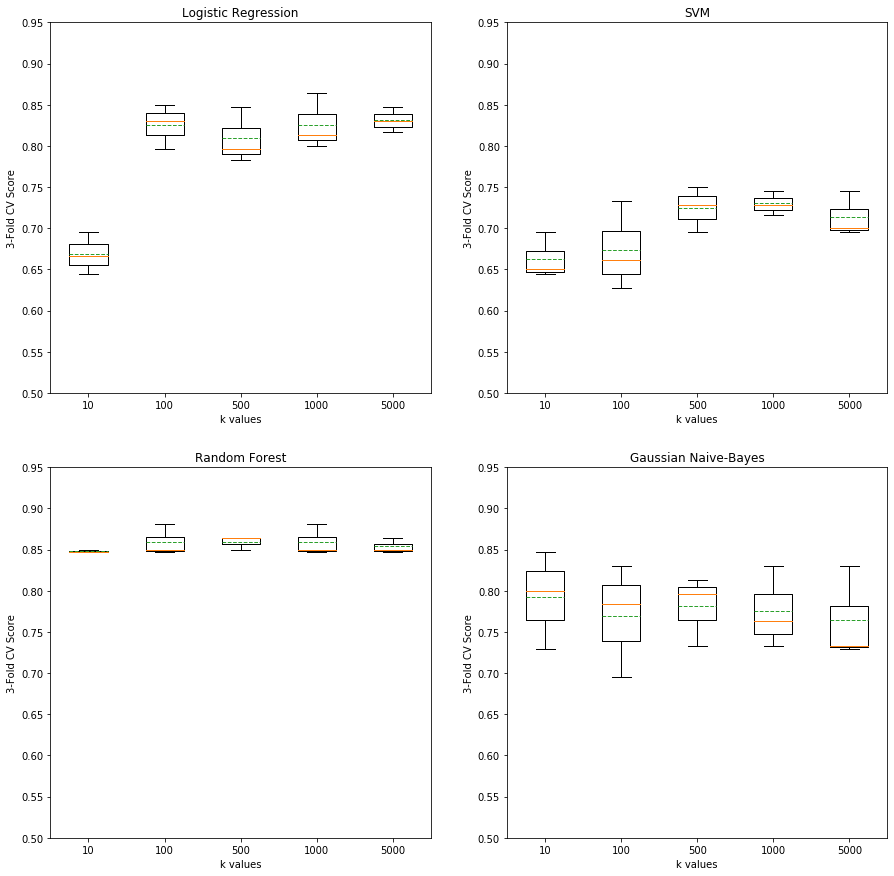

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

axes[0,0].boxplot(logreg_scores.T, labels=kvals, showmeans=True, meanline=True)
axes[0,0].set_title('Logistic Regression')
axes[0,0].set_xlabel('k values')
axes[0,0].set_ylabel('3-Fold CV Score')
axes[0,0].set_ylim(0.5,0.95)

axes[0,1].boxplot(svm_scores.T, labels=kvals, showmeans=True, meanline=True)
axes[0,1].set_title('SVM')
axes[0,1].set_xlabel('k values')
axes[0,1].set_ylabel('3-Fold CV Score')
axes[0,1].set_ylim(0.5,0.95)

axes[1,0].boxplot(clf_scores.T, labels=kvals, showmeans=True, meanline=True)
axes[1,0].set_title('Random Forest')
axes[1,0].set_xlabel('k values')
axes[1,0].set_ylabel('3-Fold CV Score')
axes[1,0].set_ylim(0.5,0.95)

axes[1,1].boxplot(gnb_scores.T, labels=kvals, showmeans=True, meanline=True)
axes[1,1].set_title('Gaussian Naive-Bayes')
axes[1,1].set_xlabel('k values')
axes[1,1].set_ylabel('3-Fold CV Score')
axes[1,1].set_ylim(0.5,0.95)

In the box and whisker plot above, the orange lines in the box denote the median, and the green dotted lines in the box denote the mean. The logistic regression classifier seems to perform generally well with k values from 100 to 5000, and Random Forest performed well across all k values, with k=10 and k=5000 producing more centralized models. SVM and Gaussian Naïve-Bayes did not perform very well, yielding lower scores than the other two classifiers. Overall, the optimal k value seems to be around 100 to 500, meaning that having around 100 genes (or a similar number in the same order of magnitude) will produce high-performing classification models. 

### 2.4 Principal Component Analysis (PCA)

k principal components were selected. The k values used were 10, 20, 30, 50, and 100.

In [6]:
# preprocess data
genes = rd.append(pcr)
X = genes.drop(columns = ['response'], axis=1)
y = genes['response']

In [8]:
# split for 3-fold cross validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 

logreg_scores = np.zeros((5, 3))
svm_scores = np.zeros((5, 3))
clf_scores = np.zeros((5, 3))
gnb_scores = np.zeros((5, 3))

logreg_f2scores = np.zeros((5, 3))
svm_f2scores = np.zeros((5, 3))
clf_f2scores = np.zeros((5, 3))
gnb_f2scores = np.zeros((5, 3))

kvals = [10, 20, 30, 50, 100]
for i in range(len(kvals)):
    k = kvals[i]
    j = 0
    for train, test in skf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        pca = PCA(n_components = k)
        Xc_train = pca.fit_transform(X_train, y_train)
        Xc_test = pca.transform(X_test)

        # Fit models
        logreg = LogisticRegression(solver='liblinear',class_weight='balanced',max_iter=500)
        logreg.fit(Xc_train, y_train)
        y_pred = logreg.predict(Xc_test)
        logreg_f2scores[i,j] = fbeta_score(y_test, y_pred, average='weighted', beta=2)
        logreg_scores[i,j] = logreg.score(Xc_test, y_test)

        svm = SVC(class_weight='balanced')
        svm.fit(Xc_train, y_train)
        y_pred = svm.predict(Xc_test)
        svm_f2scores[i,j] = fbeta_score(y_test, y_pred, average='weighted', beta=2)
        svm_scores[i,j] = svm.score(Xc_test, y_test)

        clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy')
        clf.fit(Xc_train, y_train)
        y_pred = clf.predict(Xc_test)
        clf_f2scores[i,j] = fbeta_score(y_test, y_pred, average='weighted', beta=2)
        clf_scores[i,j] = clf.score(Xc_test, y_test)

        gnb = GaussianNB()
        gnb.fit(Xc_train, y_train)
        y_pred = gnb.predict(Xc_test)
        gnb_f2scores[i,j] = fbeta_score(y_test, y_pred, average='weighted', beta=2)
        gnb_scores[i,j] = gnb.score(Xc_test, y_test)
        
        j += 1
        
mean_logreg_f2scores = np.mean(logreg_f2scores, axis=1)
mean_svm_f2scores = np.mean(svm_f2scores, axis=1)
mean_clf_f2scores = np.mean(clf_f2scores, axis=1)
mean_gnb_f2scores = np.mean(gnb_f2scores, axis=1)
total_f2scores = np.vstack((mean_logreg_f2scores, mean_svm_f2scores, mean_clf_f2scores, mean_gnb_f2scores))

print(tabulate({'Classifier': ['Logistic Regression', 'SVM', 'Random Forest', 'Gaussian NB'], \
                'k = 10': list(total_f2scores[:,0]), 'k = 20': list(total_f2scores[:,1]), \
                'k = 30': list(total_f2scores[:,2]), 'k = 50': list(total_f2scores[:,3]), \
                'k = 100': list(total_f2scores[:,4])}, headers='keys'))

Classifier             k = 10    k = 20    k = 30    k = 50    k = 100
-------------------  --------  --------  --------  --------  ---------
Logistic Regression  0.69604   0.749528  0.791493  0.791706   0.748429
SVM                  0.72944   0.769966  0.796476  0.793724   0.818578
Random Forest        0.8165    0.827963  0.824395  0.821369   0.825715
Gaussian NB          0.815001  0.81533   0.785184  0.725903   0.676897


The above table gives a summary of mean F2 scores of each classifier for the varying number of features. Based on the average F2 score across all k values, Random Forest seems to be the best classifier. 

Now let's use a box and whisker plot to visualize the performance of the classifiers for each k value.

(0.5, 0.95)

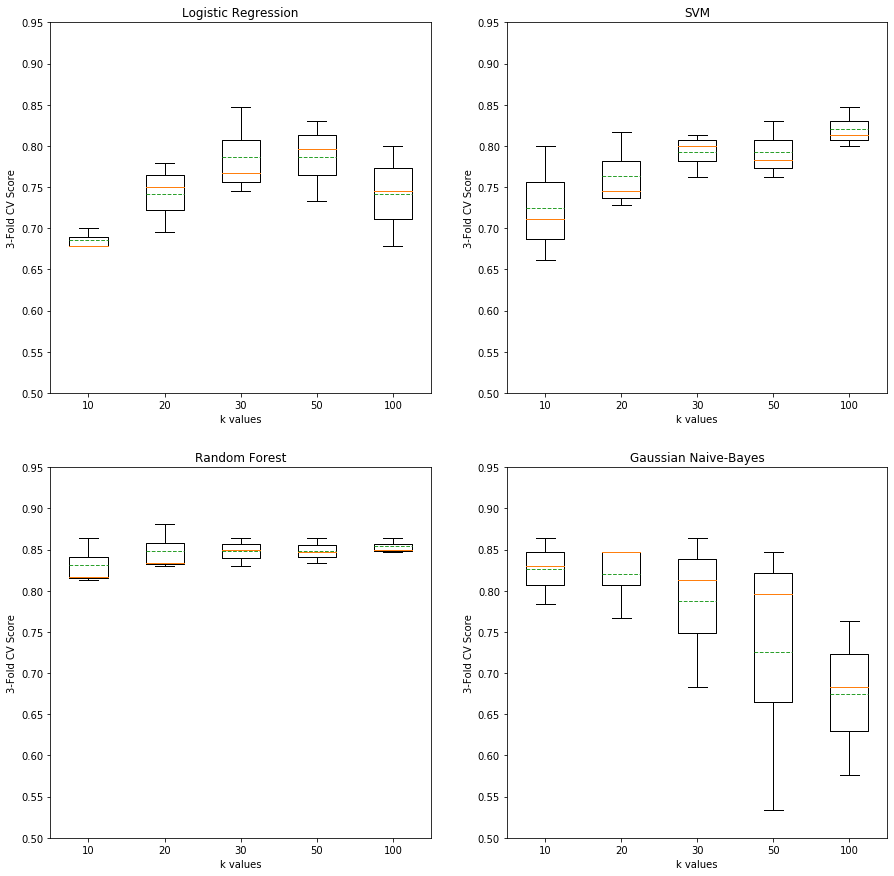

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

axes[0,0].boxplot(logreg_scores.T, labels=kvals, showmeans=True, meanline=True)
axes[0,0].set_title('Logistic Regression')
axes[0,0].set_xlabel('k values')
axes[0,0].set_ylabel('3-Fold CV Score')
axes[0,0].set_ylim(0.5,0.95)

axes[0,1].boxplot(svm_scores.T, labels=kvals, showmeans=True, meanline=True)
axes[0,1].set_title('SVM')
axes[0,1].set_xlabel('k values')
axes[0,1].set_ylabel('3-Fold CV Score')
axes[0,1].set_ylim(0.5,0.95)

axes[1,0].boxplot(clf_scores.T, labels=kvals, showmeans=True, meanline=True)
axes[1,0].set_title('Random Forest')
axes[1,0].set_xlabel('k values')
axes[1,0].set_ylabel('3-Fold CV Score')
axes[1,0].set_ylim(0.5,0.95)

axes[1,1].boxplot(gnb_scores.T, labels=kvals, showmeans=True, meanline=True)
axes[1,1].set_title('Gaussian Naive-Bayes')
axes[1,1].set_xlabel('k values')
axes[1,1].set_ylabel('3-Fold CV Score')
axes[1,1].set_ylim(0.5,0.95)

Similar to the previous plot, the orange lines in the box denote the median and the green dotted lines in the box denote the mean. For the Logistic Regression classifier, k=50 seemed to be the optimal number of components, and the Random Forest classifier performed consistently well across all k values, with k=100 yielding a very centralized model. SVM performance improved as more features were considered, while Gaussian Naïve-Bayes performance worsened. Overall, reducing the dimension of the model to about 30-50 genes seem to be ideal.

## Discussion

Based on the F2 scores then selecting genes based on the Wilcoxon rank-sum test and Kendall’s rank correlation coefficient, the Random Forest classifier performed the best. The Wilcoxon rank-sum test filtered out genes with the same gene expression level distribution for the RD response and the pCR response, and only genes that had different expression levels between the two responses were left. Then, the Kendall’s rank correlation coefficient removed any genes that were high correlated with one another, helping reduce bias that may have affected the performance of the classifier. The Random Forest classifier worked well because I was working with a relatively small dataset with class imbalance, and utilizing multiple decision trees allowed the Random Forest algorithm to minimize the effect of overfitting. Note that entropy was used to measure the quality of a split in the Random Forest classifier.

Selecting features via mutual information was the method that produced the smallest range of F2 scores across all k values and classifiers, excluding the poor performance of the Logistic Regression model at k=10. The poor performance was expected because logistic regression relies heavily on having enough datapoints and 10 features were not enough to paint the full picture, producing an overfitted model. With mutual information, we are selecting features based on their dependencies to the target labels, which is analogous to how much each of the features are contributing to the final model. Thus, mutual information can be incorporated successfully in a feature selection workflow. However, as seen in the logistic regression model for k=10, we should be aware that selecting too few features may cause the model to be susceptible to overfitting.

Compared to selection via mutual information, the performance of the classifiers built based on features selected via PCA varied more depending on the number of components chosen. The PCA algorithm identifies the principal components, defined as the directions that maximizes the variance of the data, which can be interpreted as minimizing information loss from an information theory point of view. Thus, it is not surprising that with every classifier, there will be a certain k value that optimizes the balance between simplifying the data to maximize its relevance to class labels and preserving the variation to minimize its redundancies with other features. Similar to feature selection via mutual information, k value is an important parameter to consider if we want to incorporate PCA into our feature selection workflow.

With the feature selection methods and the classifier in mind, I used the recursive feature elimination method with the Random Forest classifier to select the top 10 contributing features. They are listed as follows:

In [23]:
model = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy')
rfe = RFE(model,10)
fit = rfe.fit(Xc_train_rs, y_train)
print("Number of Features: %d" % fit.n_features_)
new_features = [Xc_train_rs.columns[i] for i in range(len(fit.ranking_)) if fit.ranking_[i] == 1]
new_rel_idx = [i for i in range(len(fit.ranking_)) if fit.ranking_[i] == 1]
print(*new_features, sep="\n")

Number of Features: 10
FECH
CCL4
BCAS1
RRAGB
CDKN2A
DGKZ
NEDD4L
SLC9A8
MGC40069///TRAC///TRAJ17///TRAV20///TRDV2///YME1L1
PAK1IP1


Note that these genes were generated based on the training set with 124 patients, 106 of which are part of the RD response group and the remaining 18 are part of the pCR response group. We implemented a 70:30 split for training to testing sets, and the ratio of the class sizes were maintained after the split. 

Now let's visualize the relationships between the ten genes using a scatter plot matrix.

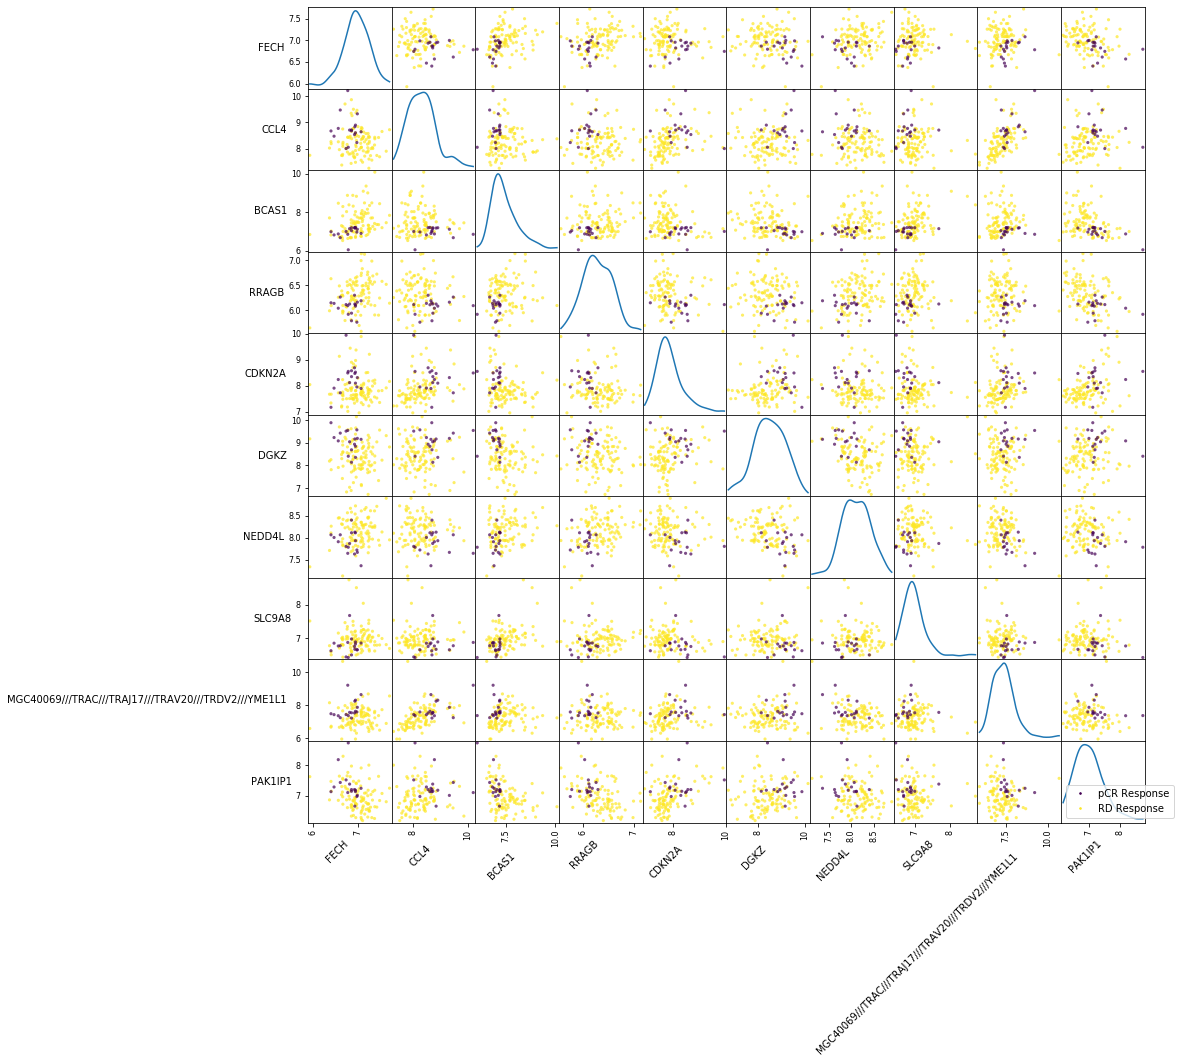

In [24]:
Xcc_train = Xc_train_rs.iloc[:,new_rel_idx]
Xcc_test = Xc_test_rs.iloc[:,new_rel_idx]

# create scatterplot matrix
from matplotlib import cm

scat_X = Xcc_train.astype(float)
scat_y = y_train
cmap = cm.get_cmap('viridis',2)
scat_ax = pd.plotting.scatter_matrix(scat_X, c=scat_y, alpha=0.7, s=40, diagonal='kde', figsize=(15,15), cmap=cmap)
for ax in scat_ax.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.xaxis.label.set_ha('right')
    ax.xaxis.label.set_va('top')
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    ax.yaxis.label.set_va('center')
handles = [plt.plot([],[], color=cmap(i), ls="", marker=".", markersize=np.sqrt(10))[0] for i in range(2)]
plt.legend(handles, ['pCR Response', 'RD Response'], loc='lower left')

The purple dots represent data points from the pCR response group, and the yellow dots represent data points from the RD response group. The graphs in the main diagonal show the kernel density estimation curve of each gene. Note that the pCR data points are mostly clustered together, which may be one of the reasons why these genes contributed the most to building the classifier. 

## Conclusion

Feature selection is very important when it comes to building models based on large datasets because it can have a large impact on its performance. I examined four feature selection methods (Wilcoxon rank-sum, Kendall’s rank correlation coefficient, Mutual information, and PCA), and evaluated the performance of four classifiers (Logistic regression, SVM, Random forest, Gaussian Naïve-Bayes) that were built based on the selected features. Due to the small size of our dataset and its class imbalance, the Wilcoxon ranksum test and Kendall’s rank correlation coefficient selected for features that produced the highest F2 score through the Random Forest classifier. However, all four methods have different strengths andweaknesses that tailor to different characteristics of a dataset, and there are a lot more metrics and statistical tests that we have not explored in the report. Just like there is no best machine learning algorithm, there is no overarching best feature selection method. Thus, it is imperative that we try different feature selection methods on different models to tailor our workflow to the characteristics of the dataset and the machine learning problem at hand. 